# 10339 - Catalysis: Homework \#3 Solutions
## Trends, Scaling Relations, and the Volcano Plot

Recall the CO oxidation reaction:
$$2 \text{CO(g)}+\text{O}_2 (\text{g}) \rightleftharpoons 2 \text{CO}_2 (\text{g})$$

with the mechanism: 
1. $$\text{CO(g) + *} \rightleftharpoons \text{CO*}$$
2. $$\text{O}_2\text{(g) + 2*} \rightleftharpoons 2\text{O*}$$
3. $$\text{CO* + O*} \rightleftharpoons \text{CO}_2\text{(g) + 2*}$$

and the standard assumptions: 

(a) The enthalpy of each species may be approximated by the electronic energy given by CatApp. 

(b) The entropy of gas-phase species may be approximated by 0.002 eV/K. 

(c) The entropy of surface-bound species (adsorbates and transition-states) may be neglected. 

(d) Pre-exponential factors may be approximated by $A = k_{B}T/h$. 

Assume the same reaction conditions used in HW2: $T=600$ K, $P_{CO} = 0.2$ bar, $P_{O_2} = 0.7$ bar, $P_{CO_2} = 0.1$ bar. 

## 1) 

Using the procedure from HW2, calculate the CO oxidation rate of each (111) metal surface (Ru, Rh, Pt, Pd, Cu, Au).

### Solution:

Using the equations we developed in Homework 2
we get the following rates:

If CatApp is used manually:

| log10(rate) | Ru | Rh | Pt | Pd | Cu | Au | 
| --- | --- | --- | --- | --- | --- | --- |
| Rate 1 is limiting | -3.06 | 2.4 | 11.19 | 10.78 | -0.46 | 1.48 |
| Rate 2 is limiting | -2.16 | -2.16 | -2.20 | -4.01 | 3.08 | -17.48 |
| Rate 3 is limiting | -10.62 | -4.32 | 5.1 | 3.03 | -4.91 | -6.45 |

If CatApp is used automatically:

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from ase.db import connect
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pickle
import copy

# Temperature
T=600 # K
# The surfaces
metals=['Ru(111)','Rh(111)','Pt(111)','Pd(111)','Cu(111)','Au(111)']

# Boltzmann constant
kB=8.617333262145*10**(-5) # eV/K
# Planck constant
h=4.135667696*10**(-15) # eV*s

kBT=kB*T
# Prefactor in TS theory
A=kBT/h

# Load data from Problem 1.
input_df=pickle.load(open('HW2_free.pkl','rb'))

def round_num(val,r=2):
    'Round a value'
    if not isinstance(val,(float,int)):
        val=val.item(0)
    return np.format_float_scientific(val,unique=False, precision=r)

def rate_eq(Ga,G,A,kBT):
    """Calculate the forward and backsward reaction rate 
       and the equilibrium constant from activation free energy and free energy"""
    k=A*np.exp(-Ga/kBT)
    Ga_inv=Ga-G
    kinv=A*np.exp(-Ga_inv/kBT)
    K=np.exp(-G/kBT)
    return k,kinv,K

def rate_eq_visualize(input_df,metals):
    'Calculate reaction reaction rate and the equilibrium constants and show them'
    pd_total={}
    for metal in metals:
        pd_dict={'Reactions':input_df['Reactions'][::2].values,'k':[],'k_inv':[],'K':[],'K=k/k_inv':[]}
        G=input_df[metal][::2].values
        Ga=input_df[metal][1::2].values
        #print('{} surface:'.format(metal))
        for r,react in enumerate(input_df['Reactions'][::2]):
            # Calculate rate and equilibrium constants 
            k,kinv,K=rate_eq(Ga[r],G[r],A,kBT)
            pd_dict['k'].append(round_num(k))
            pd_dict['k_inv'].append(round_num(kinv))
            pd_dict['K=k/k_inv'].append(round_num(k/kinv))
            pd_dict['K'].append(round_num(K))
        # Show table 
        pd_dict=pd.DataFrame(pd_dict)
        #display(pd_dict)
        pd_total[metal]=pd_dict
    return pd_total

def R1(k1,k1i,K1,K2,K3,pco,po2,pco2):
    'Rate of reaction 1'
    cov=(1+np.sqrt(K2*po2)+pco2/(K3*np.sqrt(K2*po2)))
    return (k1*pco-k1i*pco2/(K3*np.sqrt(K2*po2)))/cov

def R2(k2,k2i,K1,K2,K3,pco,po2,pco2):
    'Rate of reaction 2'
    cov=(1+pco2/(K3*K1*pco)+K1*pco)
    return 2*(k2*po2-k2i*(pco2/(K3*K1*pco))**2)/cov**2

def R3(k3,k3i,K1,K2,K3,pco,po2,pco2):
    'Rate of reaction 3'
    cov=(1+np.sqrt(K2*po2)+K1*pco)
    return (k3*K1*pco*np.sqrt(K2*po2)-k3i*pco2)/cov**2

def round_num(val,r=3):
    'Round a value'
    if not isinstance(val,(float,int)):
        val=val.item(0)
    return np.format_float_scientific(val,unique=False, precision=r)

def rate_table(reactants,rates_list,react_index,pd_total):
    'Get all the rates and visualize them in a table'
    reaction_label=['Rate {} is limiting'.format(i) for i in range(1,len(react_index)+1)]
    pd_dict={'Rate limiting':reaction_label+['Rate']}
    rates_total=[]
    for metal in pd_total:
        K_list=pd_total[metal]['K'][react_index]
        pd_dict[metal]=[]
        for i in react_index:
            argu=[pd_total[metal]['k'][i],pd_total[metal]['k_inv'][i]]+K_list.tolist()+reactants
            argu=map(float,argu)
            R=rates_list[i](*argu)
            pd_dict[metal].append(np.log10(R))
        R=min(pd_dict[metal])
        pd_dict[metal].append(R)
    return pd.DataFrame(pd_dict)


pd_total=rate_eq_visualize(input_df,metals)

# Partial pressures
pco,po2,pco2=0.2,0.7,0.1

# Reaction indices with pressures
reactants=[pco,po2,pco2]
rates_list=[R1,R1,R2,R3,R3]
react_index=[1,2,3]

# Calculate and show the rates
pd_dict=rate_table(reactants,rates_list,react_index,pd_total)
pickle.dump(pd_dict,open('rates_HW3.pkl','wb'))
display(pd_dict)

,Rate limiting,Ru(111),Rh(111),Pt(111),Pd(111),Cu(111),Au(111)
0,Rate 1 is limiting,-2.937938,2.269834,11.227126,10.661436,-0.417879,1.478566
1,Rate 2 is limiting,-2.831019,-2.160047,-2.357101,-3.857829,3.079565,-17.751438
2,Rate 3 is limiting,-10.161480,-4.533804,5.460101,2.892433,-4.869810,-6.452448
3,Rate,-10.161480,-4.533804,-2.357101,-3.857829,-4.869810,-17.751438


The rates are in log10 scale!

## 2)

For this problem we will use a single descriptor, the O* binding energy as a "descriptor". Plot log$_{10}$(rate) vs. O* binding energy for each of the metals in Problem 1.  You may plot all 3 rates per O* binding energy or only plot the ones corresponding to the rate-determining step.

### Solution


,Surface,Ref,CO,O2,CO2,[CO*]TS,CO*,O*,O-O*,O-CO*
0,Ru(111),CO=0 eV & O2=0 eV,-0.0,-0.0,-2.94,-0.0,-1.64,-2.44,0.00,-2.78
1,Rh(111),CO=0 eV & O2=0 eV,-0.0,-0.0,-2.94,0.0,-1.60,-1.82,0.00,-2.20
2,Pt(111),CO=0 eV & O2=0 eV,-0.0,-0.0,-2.94,-0.0,-1.24,-0.74,0.62,-1.27
3,Pd(111),CO=0 eV & O2=0 eV,-0.0,-0.0,-2.94,-0.0,-1.39,-0.82,0.61,-1.10
4,Cu(111),CO=0 eV & O2=0 eV,-0.0,-0.0,-2.94,-0.0,-0.36,-1.30,0.01,-1.12
5,Au(111),CO=0 eV & O2=0 eV,-0.0,0.0,-2.94,0.1,0.10,0.25,2.49,0.43


,Surface,Ref,E_O*,Rate 1 is limiting,Rate 2 is limiting,Rate 3 is limiting,Rate
0,Ru(111),CO=0 eV & O2=0 eV,-2.44,-2.937938,-2.831019,-10.161480,-10.161480
1,Rh(111),CO=0 eV & O2=0 eV,-1.82,2.269834,-2.160047,-4.533804,-4.533804
2,Pt(111),CO=0 eV & O2=0 eV,-0.74,11.227126,-2.357101,5.460101,-2.357101
3,Pd(111),CO=0 eV & O2=0 eV,-0.82,10.661436,-3.857829,2.892433,-3.857829
4,Cu(111),CO=0 eV & O2=0 eV,-1.30,-0.417879,3.079565,-4.869810,-4.869810
5,Au(111),CO=0 eV & O2=0 eV,0.25,1.478566,-17.751438,-6.452448,-17.751438


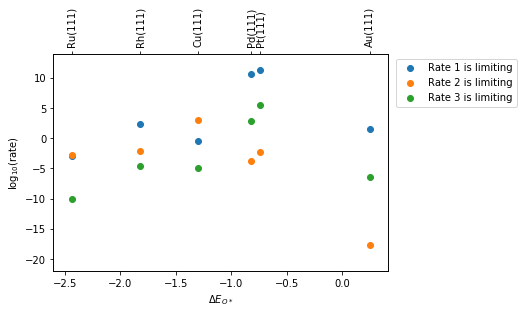

In [2]:
# The surfaces
metals=['Ru(111)','Rh(111)','Pt(111)','Pd(111)','Cu(111)','Au(111)']

# All compounds that the energy is obtained for
compounds=['CO','O2','CO2','[CO*]TS','CO*','O*','O-O*','O-CO*']

# Reactants and products for all elementary reactions including TS formation
products=[['CO*'],['[CO*]TS'],['O*','O*'],['O-O*'],['CO2'],['O-CO*']]
reactants=[['CO'],['CO'],['O2'],['O2'],['CO*','O*'],['CO*','O*']]

# Load energies from HW1.
energy_df=pickle.load(open('HW1_ener_catapp.pkl','rb'))
# Load rates from problem 1
rate_df=pickle.load(open('rates_HW3.pkl','rb'))

# The descriptor used
descriptor='O*'

def comp_energies_surf(compounds,reactants,products,pd_ener,ref,ref_txt,surfaces):
    'Compare energies by one reference for multiple surfaces'
    react=reactants+ref['Reactants']
    prod=products+ref['Products']
    pd_dict={'Surface':[],'Ref':[ref_txt]*len(surfaces)}
    for s,surf in enumerate(surfaces):
        energies=[pd_ener[key][s] for key in pd_ener.keys()]
        ener=energies+ref['Energies']
        coef_matrix=np.zeros((len(prod),len(compounds)))
        for row in range(len(coef_matrix)):
            for col in range(len(coef_matrix[0])):
                if compounds[col] in prod[row]:
                    coef_matrix[row,col]+=prod[row].count(compounds[col])
                if compounds[col] in react[row]:
                    coef_matrix[row,col]-=react[row].count(compounds[col])

        comp_energy=np.linalg.solve(coef_matrix,ener)
        pd_dict['Surface'].append(surf)
        for e in range(len(compounds)):
            if compounds[e] not in pd_dict:
                pd_dict[compounds[e]]=[]
            pd_dict[compounds[e]].append(round(comp_energy[e],2))
    return pd.DataFrame(pd_dict)


def rate_descriptor(pd_surf,pd_rate,descriptor):
    'Get the rates for different rate-determining steps as a function one descriptor'
    pd_dict={'Surface':list(pd_surf['Surface']),'Ref':list(pd_surf['Ref']),'E_'+descriptor:list(pd_surf[descriptor])}
    for surf in pd_surf['Surface']:
        for r,rate in enumerate(rate_df['Rate limiting']):
            if rate not in pd_dict:
                pd_dict[rate]=[]
            pd_dict[rate].append(rate_df[surf][r])
    return pd.DataFrame(pd_dict)


# Reference A (CO=0 eV , O2=0 eV)
ref={'Reactants':[[],[]],'Products':[['CO'],['O2']],'Energies':[0,0]}
# Get the energies of all compounds compared to Reference A
pd_surf=comp_energies_surf(compounds,reactants,products,energy_df,ref,'CO=0 eV & O2=0 eV',metals)
display(pd_surf)
pickle.dump(pd_surf,open('HW3_compound_energies.pkl','wb'))

# Get the rates in a table together with the energy descriptor
rate_desc_df=rate_descriptor(pd_surf,rate_df,descriptor)
display(rate_desc_df)
pickle.dump(rate_desc_df,open('rates_HW3_scatter.pkl','wb'))

# Plot the volcano
fig=plt.figure()
ax1=fig.add_subplot(111)
ax2=ax1.twiny()
for r,rate in enumerate(rate_df['Rate limiting'][:-1]):
    ax1.scatter(rate_desc_df['E_O*'],rate_desc_df[rate],label=rate)

ax2.set_xticks(rate_desc_df['E_O*'].values)
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(rate_desc_df['Surface'].values,rotation=90)    
ax1.set_ylabel('log$_{10}$(rate)')
ax1.set_xlabel('$\Delta E_{O*}$')
ax1.legend(bbox_to_anchor=(1.4,1))
plt.ylim(-22,14)
plt.show()

## 3)

Form "scaling relations" between the descriptor energy (O* binding energy) and all energies necessary to calculate the reaction rate ($E_{CO*}$, $E_{O*}$, E$_{O-O*}$, E$_{O-CO*}$). You do not need to scale the transition state of reaction (1) with the descriptor - just assume that there is no additional barrier.  Recall HW1 in order to express all energies relative to CO$_{(g)}$ and O$_{2(g)}$. Discuss why the linear fit here might not be as good as expected, and how you might create more accurate scaling relations for this problem. 


### Solution

For simplicity and by convention, we will
scale the electronic energies with each other. We can improve the scaling for $E_{O*}$ vs $E_{O-O*}$
significantly by dropping the first two points (which were 0) and
making a linear scaling out of the remaining four points.  You can see
an example of the scaling relations in Figure 2. The linear fit for 
$E_{O*}$ vs. $E_{O-O*}$ and $E_{O*}$ vs. $E_{O-CO*}$ appear to be
fairly reasonable, but $E_{O*}$ vs. $E_{CO*}$ shows a very
poor fit due to the fact that $E_{CO*}$ and $E_{O*}$ bind through
different atoms and are known to scale poorly with each other.  No
more reasonable fit can be generated if we stick to a one-descriptor
model.  Ideally, a 2-D volcano plot using $E_{O*}$ vs. $E_{CO*}$ as
descriptors would be more accurate.

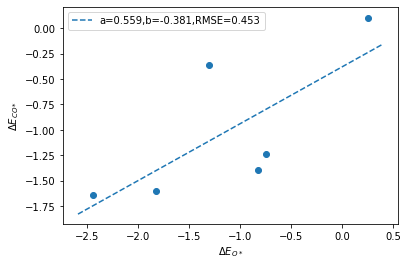

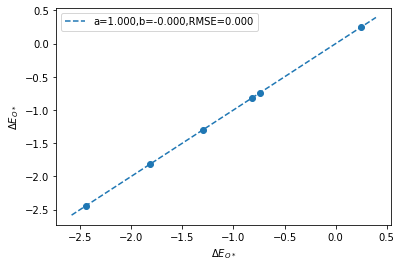

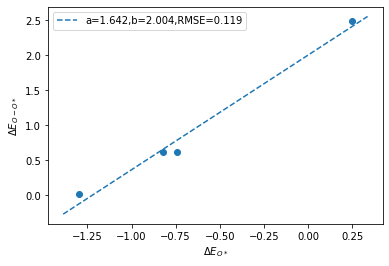

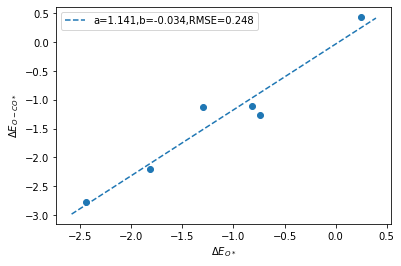

,Compounds,a,b,RMSE
0,CO*,0.559230,-3.813481e-01,4.525266e-01
1,O*,1.000000,-2.324379e-16,5.424777e-16
2,O-O*,1.641880,2.003826e+00,1.186007e-01
3,O-CO*,1.140508,-3.411838e-02,2.482032e-01


In [3]:
# The descriptor used
descriptor='O*'

scaling_comp=['CO*','O*','O-O*','O-CO*']

# Load compound energies from problem 2
pd_energy_surf=pickle.load(open('HW3_compound_energies.pkl','rb'))

# Plot the 4 figures
pd_scaling={'Compounds':[],'a':[],'b':[],'RMSE':[]}
for comp in scaling_comp:
    fig,ax=plt.subplots()
    x=pd_energy_surf[descriptor].values
    y=pd_energy_surf[comp].values
    if comp=='O-O*':
        x=x[2:]
        y=y[2:]
    ax.scatter(x,y)
    # Make linear fit
    a,b=np.polyfit(x,y,1) 
    x_axis=np.linspace(ax.get_xbound()[0],ax.get_xbound()[1],50)
    y_pred=a*x+b
    # Calculate root-mean-square error
    rmse=np.sqrt(np.mean((y-y_pred)**2))
    plt.plot(x_axis,a*x_axis+b,'--',label='a={:.3f},b={:.3f},RMSE={:.3f}'.format(a,b,rmse))
    ylab='$\Delta E_{'+comp+'}$'
    plt.ylabel(ylab)
    plt.xlabel('$\Delta E_{O*}$')
    ax.legend(loc=0)
    plt.show()
    # Save linear scaling  
    pd_scaling['Compounds'].append(comp)
    pd_scaling['a'].append(a)
    pd_scaling['b'].append(b)
    pd_scaling['RMSE'].append(rmse)

pd_scaling=pd.DataFrame(pd_scaling)
display(pd_scaling)
pickle.dump(pd_scaling,open('Linear_scaling_HW3.pkl','wb'))

## 4)

Combine the scaling relations from Problem 3 with the procedure in HW2 in order to calculate the rate as a continuous function of the descriptor, and plot along with the individual metal rates from Problem 2.

Mathematically this can be expressed as:

$r = \mathrm{overall\;rates} = f(\vec{K})$ (from HW2) 

$\vec{K} = \mathrm{equilibrium/rate\;constants} = f(\vec{E})$ (textbook equations, HW2) 

$\vec{E} = E_{CO*}, E_{O*}, E_{O-O*}, E_{O-CO*} = f(E_{O*})$ (Problem 3) 


*Note: you will need to calculate the rate for each potential rate-limiting step and combine them to get the relevant rate, since the rate-limiting step may change as a function of the descriptor.*


### Solution

The basic idea of this problem is that
now that we have the scaling relations, we only need one 
number/descriptor, $E_{O*}$ to calculate a rate of CO oxidation by
following the pathway $E_{O*}$ $\rightarrow$ $E_{\text{all adsorbates}}$ $\rightarrow$
$G_{\text{all adsorbates}}$ $\rightarrow$ $\Delta G_{rxns}$/$\Delta G_{a,rxns}$ 
$\rightarrow$ Ks and ks $\rightarrow$ rates.  The hard part now is just putting that all together
in a robust way. Please see the attached code for a full
example.  The actual solution is shown in Figure 1.  One key point
to remember is that for a given rate-determining step (RDS), the volcano
generated from scaling should more or less go through the actual rates
calculated for the metals.  This is because your scaling relations are
a linear regression of the actual binding energies of the metals, so the final rates should have roughly equal deviation above and below the line
(for example, there are roughly the same blue points above and below the
blue line).  This is a useful sanity check for the question of "Did I 
do the whole conversion of descriptor values to rates correctly?" 


Another important point is the issue of the free energy of transition
states. You might have noticed in your own homework that in the strong-binding regime of the volcano
near Ru(111), the line for step 2 being rate determining lies far above
the points.  This did not show up as an issue in the final volcano
for those who only plotted the most relevant RDS because step 2
was not rate-determining in that regime.  The cause of this problem is
due to the way absolute Es were converted to absolute Gs 
before turning them into $\Delta G_{rxns}$/$\Delta G_{a,rxns}$.  We
mentioned that $\Delta G_{a,rxns}$ can never be lower than $\Delta G_{rxns}$ or 0.  Although this is true, in the case of oxygen dissociation
(Reaction 2), an additional constraint needed to be enforced:
$\Delta G_{a,2}$ needed to be at least 1.2 OR $E_{O-O*}$ needed to
be forced to at least 0 (relative to $E_{O_2}$ - be careful applying
these types of additional constraints to other problems in the future).  
This resulted in the very strange (and very wrong) intermediate result
that $\Delta G_{a,2}$ for Ru(111) was 1.2 eV, but $\Delta G_{a,2}$ for
a theoretical metal that binds O* very similarly to Ru(111) was 0.0
eV!  If you think about it enough, it should make sense why 
this happened and why this would cause greatly overestimated rates
in that regime.

,Descriptor,CO,O2,CO2,CO*,O*,O-O*,O-CO*,G1,Ga1,G2,Ga2,G3,Ga3
0,-3.000000,0.0,0.0,-2.945,-2.059039,-3.000000,-2.921812,-3.455642,-0.859039,0.000000,-4.800000,1.200000,0.914039,2.114039
1,-2.959596,0.0,0.0,-2.945,-2.036443,-2.959596,-2.855474,-3.409561,-0.836443,0.000000,-4.719192,1.200000,0.851039,2.051039
2,-2.919192,0.0,0.0,-2.945,-2.013848,-2.919192,-2.789135,-3.363480,-0.813848,0.000000,-4.638384,1.200000,0.788040,1.988040
3,-2.878788,0.0,0.0,-2.945,-1.991253,-2.878788,-2.722796,-3.317399,-0.791253,0.000000,-4.557576,1.200000,0.725041,1.925041
4,-2.838384,0.0,0.0,-2.945,-1.968658,-2.838384,-2.656458,-3.271318,-0.768658,0.000000,-4.476768,1.200000,0.662042,1.862042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.838384,0.0,0.0,-2.945,0.087501,0.838384,3.380352,0.922065,1.287501,1.287501,2.876768,4.580352,-5.070885,0.000000
96,0.878788,0.0,0.0,-2.945,0.110097,0.878788,3.446690,0.968146,1.310097,1.310097,2.957576,4.646690,-5.133884,0.000000
97,0.919192,0.0,0.0,-2.945,0.132692,0.919192,3.513029,1.014227,1.332692,1.332692,3.038384,4.713029,-5.196884,0.000000
98,0.959596,0.0,0.0,-2.945,0.155287,0.959596,3.579367,1.060308,1.355287,1.355287,3.119192,4.779367,-5.259883,0.000000


,Descriptor,k1,k-1,K1,k2,k-2,K2,k3,k-3,K3,RDS1,RDS2,RDS3,R
0,-3.000000,1.250197e+13,7.609773e+05,1.642884e+07,1.040931e+03,5.002610e-38,2.080777e+40,2.186934e-05,1.040931e+03,2.100939e-08,-7.683653,-9.869724,-18.225189,-18.225189
1,-2.959596,1.250197e+13,1.178047e+06,1.061245e+07,1.040931e+03,2.387562e-37,4.359809e+39,7.396149e-05,1.040931e+03,7.105318e-08,-7.344274,-9.490142,-17.546431,-17.546431
2,-2.919192,1.250197e+13,1.823701e+06,6.855275e+06,1.040931e+03,1.139496e-36,9.135019e+38,2.501357e-04,1.040931e+03,2.402998e-07,-7.004895,-9.110560,-16.867673,-16.867673
3,-2.878788,1.250197e+13,2.823219e+06,4.428268e+06,1.040931e+03,5.438394e-36,1.914042e+38,8.459517e-04,1.040931e+03,8.126873e-07,-6.665516,-8.730979,-16.188915,-16.188915
4,-2.838384,1.250197e+13,4.370545e+06,2.860506e+06,1.040931e+03,2.595546e-35,4.010453e+37,2.860985e-03,1.040931e+03,2.748485e-06,-6.326137,-8.351397,-15.510157,-15.510157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.838384,1.916208e+02,1.250197e+13,1.532725e-11,4.204536e-26,6.130601e-02,6.858277e-25,1.250197e+13,3.187258e-30,3.922485e+42,1.583473,-25.230154,-10.575871,-25.230154
96,0.878788,1.237804e+02,1.250197e+13,9.900868e-12,1.165463e-26,8.110388e-02,1.437001e-25,1.250197e+13,9.424259e-31,1.326573e+43,1.393682,-25.787373,-11.105041,-25.787373
97,0.919192,7.995779e+01,1.250197e+13,6.395614e-12,3.230570e-27,1.072952e-01,3.010919e-26,1.250197e+13,2.786617e-31,4.486434e+43,1.203891,-26.344593,-11.634211,-26.344593
98,0.959596,5.164994e+01,1.250197e+13,4.131343e-12,8.954880e-28,1.419446e-01,6.308717e-27,1.250197e+13,8.239621e-32,1.517299e+44,1.014100,-26.901812,-12.163381,-26.901812


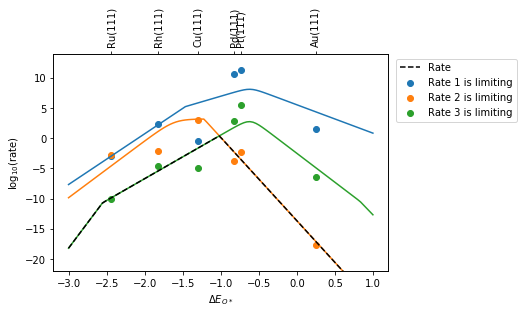

In [4]:
# The descriptor O* range
descriptor=np.linspace(-3,1,100)

# Partial pressures
pco,po2,pco2=0.2,0.7,0.1

# Entropies for each compound
S_compound={'CO':0.002,'O2':0.002,'CO2':0.002,'[CO*]TS':0.002,'CO*':0.000,'O*':0.000,'O-O*':0.000,'O-CO*':0.000}

# Fixed energies that are independent of the surfaces
energi_fixed={'CO':0.00,'O2':0.00,'CO2':-2.945}

# Reactants and products for all elementary reactions including TS formation
products=[['CO*'],['O*','O*'],['CO2']]
products_ts=[['[CO*]TS'],['O-O*'],['O-CO*']]
reactants=[['CO'],['O2'],['CO*','O*']]

# Temperature
T=600 # K

# Boltzmann constant
kB=8.617333262145*10**(-5) # eV/K
# Planck constant
h=4.135667696*10**(-15) # eV*s

kBT=kB*T
# Prefactor in TS theory
A=kBT/h


def rate_eq(Ga,G,A,kBT):
    """Calculate the forward and backsward reaction rate 
       and the equilibrium constant from activation free energy and free energy"""
    k=A*np.exp(-Ga/kBT)
    Ga_inv=Ga-G
    kinv=A*np.exp(-Ga_inv/kBT)
    K=np.exp(-G/kBT)
    return k,kinv,K

def R1(k1,k1i,K1,K2,K3,pco,po2,pco2):
    'Rate of reaction 1'
    cov=(1+np.sqrt(K2*po2)+pco2/(K3*np.sqrt(K2*po2)))
    return (k1*pco-k1i*pco2/(K3*np.sqrt(K2*po2)))/cov

def R2(k2,k2i,K1,K2,K3,pco,po2,pco2):
    'Rate of reaction 2'
    cov=(1+pco2/(K3*K1*pco)+K1*pco)
    return 2*(k2*po2-k2i*(pco2/(K3*K1*pco))**2)/cov**2

def R3(k3,k3i,K1,K2,K3,pco,po2,pco2):
    'Rate of reaction 3'
    cov=(1+np.sqrt(K2*po2)+K1*pco)
    return (k3*K1*pco*np.sqrt(K2*po2)-k3i*pco2)/cov**2

def free_energy_descriptor(descriptor,pd_scaling,fixed_e,reactants,products_ts,products):
    'Calculate the free energy from a descriptor with linear relations'
    # Calculate enthalpies
    pd_dict={'Descriptor':descriptor}
    # Use the fixed energies
    for comp in fixed_e.keys():
        pd_dict[comp]=np.array([fixed_e[comp]]*len(descriptor))
    # Calculate O*, CO*, O-O* and O-CO* from the linear scaling relations
    for c,comp in enumerate(pd_scaling['Compounds']):
        pd_dict[comp]=pd_scaling['a'][c]*descriptor+pd_scaling['b'][c]
    
    # Calculate reaction free energies
    for r in range(len(reactants)):
        pd_dict['G'+str(r+1)]=np.array([0]*len(descriptor))
        pd_dict['Ga'+str(r+1)]=np.array([0]*len(descriptor))
        Grea=0
        S_change=0
        Sa_change=0
        # Calculate the enthalpies and entropies for the product 
        for prod in products[r]:
            if prod in pd_dict.keys():
                pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+pd_dict[prod]
            else:
                pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+np.array([0]*len(descriptor))
            S_change=S_change-T*S_compound[prod]
        # Calculate the enthalpies and entropies for the trainsition state 
        for prod in products_ts[r]:
            if prod in pd_dict.keys():
                pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+pd_dict[prod]
            else:
                pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+np.array([0]*len(descriptor))
            Sa_change=Sa_change-T*S_compound[prod]
        # Calculate the enthalpies and entropies for the reactants 
        for rea in reactants[r]:
            if rea in pd_dict.keys():
                Grea=Grea+pd_dict[rea]
            else:
                Grea=Grea+np.array([0]*len(descriptor))  
            S_change=S_change-(-T*S_compound[rea])
            Sa_change=Sa_change-(-T*S_compound[rea])
        # Calculate the enthalpy change
        pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]-Grea
        pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]-Grea
        # The activation energy is the largest energy before the entropy is taking into account
        pd_dict['Ga'+str(r+1)]=np.max(np.array([pd_dict['G'+str(r+1)],pd_dict['Ga'+str(r+1)],[0]*len(descriptor)]),axis=0)
        # Free energy
        pd_dict['G'+str(r+1)]=pd_dict['G'+str(r+1)]+S_change
        pd_dict['Ga'+str(r+1)]=pd_dict['Ga'+str(r+1)]+Sa_change
        # Important extra line so that the activation free energy is the largest
        pd_dict['Ga'+str(r+1)]=np.max(np.array([pd_dict['G'+str(r+1)],pd_dict['Ga'+str(r+1)],[0]*len(descriptor)]),axis=0)

    pd_dict=pd.DataFrame(pd_dict)
    return pd_dict

def rates_descriptor(descriptor,pd_free,A,kBT,pressures,rates_list):
    'Calculate the rates for each descriptor value'
    pd_rates={'Descriptor':descriptor}
    rate_constants=[]
    # Rate and equilibrium constants 
    for r in range(len(reactants)):
        pd_rates['k'+str(r+1)],pd_rates['k-'+str(r+1)],pd_rates['K'+str(r+1)]=rate_eq(pd_free['Ga'+str(r+1)],pd_free['G'+str(r+1)],A,kBT)
        rate_constants.append(np.array(pd_rates['K'+str(r+1)]))
    # Log10 rates
    for r in rates_list.keys():
        pd_rates['RDS'+r]=np.log10(rates_list[r](pd_rates['k'+r],pd_rates['k-'+r],*rate_constants,*pressures))
    # Reaction rate
    pd_rates['R']=np.min([pd_rates['RDS'+r] for r in rates_list.keys()],axis=0)
    
    pd_rates=pd.DataFrame(pd_rates)
    return pd_rates


# Rate-determining steps and their labels
rates_list={'1':R1,'2':R2,'3':R3}
# Pressures
pressures_p=[pco,po2,pco2]
    
# Enthalpies from linear scaling relations
pd_scaling=pickle.load(open('Linear_scaling_HW3.pkl','rb'))

pd_free=free_energy_descriptor(descriptor,pd_scaling,energi_fixed,reactants,products_ts,products)
display(pd_free)

pd_rates=rates_descriptor(descriptor,pd_free,A,kBT,pressures_p,rates_list)
display(pd_rates)
pickle.dump(pd_rates,open('Rates_descriptor_HW3.pkl','wb'))

# Load rates from problem 1 to make the scatter plot
rate_df=pickle.load(open('rates_HW3.pkl','rb'))


# Plot the volcano
fig=plt.figure()
ax1=fig.add_subplot(111)
ax2=ax1.twiny()
for r,rate in enumerate(rate_df['Rate limiting'][:-1]):
    ax1.scatter(rate_desc_df['E_O*'],rate_desc_df[rate],label=rate)
for r in range(len(reactants)):
    ax1.plot(pd_rates['Descriptor'],pd_rates['RDS'+str(r+1)])
ax1.plot(pd_rates['Descriptor'],pd_rates['R'],'k--',label='Rate')
ax2.set_xticks(rate_desc_df['E_O*'].values)
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(rate_desc_df['Surface'].values,rotation=90)    
ax1.set_ylabel('log$_{10}$(rate)')
ax1.set_xlabel('$\Delta E_{O*}$')
ax1.legend(bbox_to_anchor=(1.4,1))
plt.ylim(-22,14)
plt.show()

## 5)

Based on the "volcano plot" from Problem 4, what is the optimal O* binding energy for the CO oxidation reaction? Use the principles discussed in the lectures to suggest potential new catalysts which might be good for this reaction.


### Solution

Solution: Based on the intersection of the left
and right legs of the volcano, the optimum appears to be around 
-1.0 eV for $E_{O*}$. You can look up oxygen binding energies in CatApp
(they are just half of oxygen dissociation energies).  One very
reasonable candidate for this is Pt(211), but we accepted a wide
variety of strategies and answers.

In [5]:
# Connect to the CatApp database
catapp=connect('catapp.db')

def reaction(catapp,reverse=False,**kwargs):
    """Download reactions from CatApp. ab -> a + b if reverse=False
        Parameters :
            catapp : database
                The CatApp database
            reverse : bool
                if reverse=False: ab -> a + b or reverse=True: a + b -> ab
            kwargs : dict
                A dictionary with a, b, ab and the surface
        Returns : 
            output : list
                Output is a list with the reaction, the surface, 
                energy of the reaction and the activation energy
    """
    output=[]
    for row in catapp.select(**kwargs):
        er=row.er
        ea=row.ea
        ea=np.max([0,er,ea])
        if reverse==True:
            er=-er
            ea+=er
            # The activation energy must be the largest
            ea=np.max([0,er,ea])
            react='{} + {} -> {}'.format(row.a,row.b,row.ab)
            surf=row.surface
        else:
            react='{} -> {} + {}'.format(row.ab,row.a,row.b)
            surf=row.surface
        output.append((react,surf,er,ea))
    return output
        
def reaction_dict(catapp,reverse=False,react_list=[],pd_react=None,**kwargs):
    """A wrapper that makes a dict of the data from CatApp
        Parameters :
            catapp : database
                The CatApp database
            reverse : bool
                if reverse=False: ab -> a + b or reverse=True: a + b -> ab
            react_list : list of str
                A list of all the reactions (can be continued in a new function call)
            pd_react : dict
                A dictionary with the surfaces, energy differences and activation energies
                that can be continued in a new function call
            kwargs : dict
                A dictionary with a, b, ab and the surface
        Returns : 
            pd_react : dict
                A dictionary with the surface, 
                energy of the reaction and the activation energy
            react_list : list
                A list of all the reactions
    """
    if pd_react is None:
        pd_react={'Surface':[],'E_diff':[],'Ea':[]}
    for r in reaction(catapp,reverse=reverse,**kwargs):
        react,surf,er,ea=list(r)
        pd_react['Surface'].append(surf)
        if react not in react_list:
            react_list.append(react)
        pd_react['E_diff'].append(er)
        pd_react['Ea'].append(ea)
    return pd_react,react_list
    

# Get all the surfaces available for the oxygen dissociation energies
pd_dict={'Surface':[],'E_diff':[],'Ea':[]} 
pd_dict,react_list=reaction_dict(catapp,reverse=False,\
                                     pd_react=pd_dict,**{'ab':'O2'})

print('The reaction:',react_list)

# Optimal binding energy of O*
rate_df=pickle.load(open('Rates_descriptor_HW3.pkl','rb'))
i_max=np.argmax(np.array(rate_df['R']))
eo_best=rate_df['Descriptor'][i_max]
print('Optimal E(O*):',round(eo_best,3),'eV')

# Show the different surfaces binding energy to O*
pd_dict=pd.DataFrame(pd_dict)
pd_dict['O*']=pd_dict['E_diff']/2
pd_dict['E_diff-max']=abs(pd_dict['O*']-eo_best)
# Sort them after best potential candidates
pd_dict=pd_dict.sort_values(by=['E_diff-max'])
display(pd_dict)


The reaction: ['O2 -> O* + O*']
Optimal E(O*): -1.02 eV


,Surface,E_diff,Ea,O*,E_diff-max
41,Pt(211),-2.090,0.17,-1.045,0.024798
35,Pt(532),-2.190,0.00,-1.095,0.074798
39,Pt(311),-2.290,0.02,-1.145,0.124798
36,Pd(532),-1.790,0.00,-0.895,0.125202
40,Pt(110),-1.730,0.03,-0.865,0.155202
45,Pd(111),-1.630,0.61,-0.815,0.205202
37,Pd(211),-1.570,0.00,-0.785,0.235202
29,Cu(110),-2.530,0.00,-1.265,0.244798
38,Cu(111),-2.590,0.01,-1.295,0.274798
47,Pt(111),-1.490,0.62,-0.745,0.275202


## 6)

Do any of the transition metal points on the "volcano plot" from Problem 4 appear to be anomalous? If so, discuss why these point(s) may appear to be too high or too low compared to the scaling-generated volcano.  You may wish to consult the plots generated in Problem 3 to help your reasoning.


### Solution

Solution: In Figure 1, Cu(111) is the obvious outlier
in the case that reaction 3 is rate-limiting.
The most obvious thing to check was which scaling relations Cu(111)
appeared to be outliers for and try to reason its position relative
to the generated volcano by using that.  Interestingly Cu(111) is
an outlier for $E_{O-CO*}$ *but in the wrong direction*.  It
has a lower transition state energy for this reaction than the scaling
would predict, which means the metal should be above the line, not
below it.  The real reason was actually due to the (much poorer) 
$E_{CO*}$ vs $E_{O*}$ scaling, where the actual point for Cu(111) is
greatly above the scaling.  This gives a much lower equilibrium coverage
of *CO than predicted, which would result in the lower than predicted
rate for reaction 3.